## Utils

In [1]:
import numpy as np
import tensorflow as tf

def uniform(shape, scale=0.5, name=None):
    """Uniform init."""
    initial = tf.random.uniform(shape, minval=-scale, maxval=scale, dtype=tf.float64)
    return tf.Variable(initial, name=name)

def glorot(shape, name=None):
    """Glorot & Bengio init."""
    init_range = np.sqrt(6.0/(shape[0]+shape[1]))
    initial = tf.random.uniform(shape=shape, minval=-init_range, maxval=init_range, dtype=tf.float64)
    return tf.Variable(initial, name=name)

def zeros(shape, name=None):
    """All zeros"""
    initial = tf.zeros(shape, dtype=tf.float64)
    return tf.Variable(initial, name=name)

def ones(shape, name=None):
    """All ones"""
    initial = tf.ones(shape, dtype=tf.float64)
    return tf.Variable(initial, name=name)

In [2]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking"""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_accuracy(preds, labels, mask):
    """Accuracy with masking"""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [3]:
import re
import sys
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh

def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def load_corpus(dataset_str):
    """
    Loads input corpus from gcn/data directory
    ind.dataset_str.x => the feature vectors of the training docs as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test docs as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training docs/words
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training docs as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test docs as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.adj => adjacency matrix of word/doc nodes as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.train.index => the indices of training docs in original doc list.
    All objects above must be saved using python pickle module.
    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """

    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'adj']
    objects = []
    for i in range(len(names)):
        with open('cleaned_data/' + dataset_str + '/graph/ind.' + dataset_str + '.' + names[i], 'rb') as f:
            # with open("./data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, adj = tuple(objects)
    # print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

    features = sp.vstack((allx, tx)).tolil()
    labels = np.vstack((ally, ty))
    # print(len(labels))

    train_idx_orig = parse_index_file('cleaned_data/' + dataset_str + '/graph/' + dataset_str + '.train.index')
    train_size = len(train_idx_orig)

    val_size = train_size - x.shape[0]
    test_size = tx.shape[0]

    idx_train = range(len(y))
    idx_val = range(len(y), len(y) + val_size)
    idx_test = range(allx.shape[0], allx.shape[0] + test_size)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size


def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)

    return sparse_to_tuple(features)



def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))

    return sparse_to_tuple(adj_normalized)



def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i]
                      for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict


def loadWord2Vec(filename):
    """Read Word Vectors"""
    vocab = []
    embd = []
    word_vector_map = {}
    file = open(filename, 'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        if(len(row) > 2):
            vocab.append(row[0])
            vector = row[1:]
            length = len(vector)
            for i in range(length):
                vector[i] = float(vector[i])
            embd.append(vector)
            word_vector_map[row[0]] = vector

    print('Loaded Word Vectors!')
    file.close()
    return vocab, embd, word_vector_map


def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

## Preprocess

In [4]:
# Remove words
import sys
import nltk
from nltk.wsd import lesk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
#
# if len(sys.argv) != 2:
#     sys.exit("Use: python remove_words.py <dataset>")

dataset = "R8"

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

doc_content_list = []
if dataset == 'CHINESE' or dataset == 'THUCTC':
    with open('./cleaned_data/' + dataset + '/corpus/' + dataset + '.txt', 'r') as f:
        for line in f.readlines():
            doc_content_list.append(line.strip())
else:
    with open('./cleaned_data/' + dataset + '/corpus/' + dataset + '.txt', 'rb') as f:
        for line in f.readlines():
            doc_content_list.append(line.strip().decode('latin1'))

word_freq = {}  # to remove rare words

for doc_content in doc_content_list:
    if dataset == 'CHINESE' or dataset == 'THUCTC':
        temp = doc_content
    else:
        temp = clean_str(doc_content)

    words = temp.split()
    for word in words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

clean_docs = []
for doc_content in doc_content_list:
    if dataset == 'CHINESE' or dataset == 'THUCTC':
        temp = doc_content
    else:
        temp = clean_str(doc_content)
    words = temp.split()
    doc_words = []
    for word in words:
        # word not in stop_words and word_freq[word] >= 5
        if dataset == 'mr':
            doc_words.append(word)
        elif word not in stop_words and word_freq[word] >= 5:
            doc_words.append(word)

    doc_str = ' '.join(doc_words).strip()
    clean_docs.append(doc_str)

clean_corpus_str = '\n'.join(clean_docs)

with open('./cleaned_data/' + dataset + '/' + dataset + '_clean.txt', 'w') as f:
    f.write(clean_corpus_str)
print("finish")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\firqa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


finish


In [5]:
## Build Graph
import os
import sys
import random
import numpy as np
import pickle as pkl
from math import log
from sklearn import svm
import scipy.sparse as sp
from nltk.corpus import wordnet as wn
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer


dataset = "R8"

word_embeddings_dim = 300
word_vector_map = {}

# shuffling
doc_name_list = []
doc_train_list = []
doc_test_list = []

with open('./cleaned_data/' + dataset + '/' + dataset + '.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        doc_name_list.append(line.strip())
        temp = line.split("\t")
        if temp[1].find('test') != -1:
            doc_test_list.append(line.strip())
        elif temp[1].find('train') != -1:
            doc_train_list.append(line.strip())

doc_content_list = []
with open('./cleaned_data/' + dataset + '/' + dataset + '_clean.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        doc_content_list.append(line.strip())

train_ids = []
for train_name in doc_train_list:
    train_id = doc_name_list.index(train_name)
    train_ids.append(train_id)

random.shuffle(train_ids)

train_ids_str = '\n'.join(str(index) for index in train_ids)
with open('./cleaned_data/' + dataset + '/graph/' + dataset + '.train.index', 'w') as f:
    f.write(train_ids_str)

test_ids = []
for test_name in doc_test_list:
    test_id = doc_name_list.index(test_name)
    test_ids.append(test_id)

random.shuffle(test_ids)

test_ids_str = '\n'.join(str(index) for index in test_ids)
with open('./cleaned_data/' + dataset + '/graph/' + dataset + '.test.index', 'w') as f:
    f.write(test_ids_str)

ids = train_ids + test_ids

print("data size {}".format(len(ids)))

print("adding...")
shuffle_doc_name_list = []
shuffle_doc_words_list = []
for id in ids:
    shuffle_doc_name_list.append(doc_name_list[int(id)])
    shuffle_doc_words_list.append(doc_content_list[int(id)])
shuffle_doc_name_str = '\n'.join(shuffle_doc_name_list)
shuffle_doc_words_str = '\n'.join(shuffle_doc_words_list)

with open('./cleaned_data/' + dataset + '/' + dataset + '_shuffle.txt', 'w') as f:
    f.write(shuffle_doc_name_str)

with open('./cleaned_data/' + dataset + '/corpus/' + dataset + '_shuffle.txt', 'w') as f:
    f.write(shuffle_doc_words_str)

# build vocab
print('building...')
word_freq = {}
word_set = set()
for doc_words in shuffle_doc_words_list:
    words = doc_words.split()
    for word in words:
        word_set.add(word)
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

vocab = list(word_set)
vocab_size = len(vocab)

word_doc_list = {}

for i in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    appeared = set()
    for word in words:
        if word in appeared:
            continue
        if word in word_doc_list:
            doc_list = word_doc_list[word]
            doc_list.append(i)
            word_doc_list[word] = doc_list
        else:
            word_doc_list[word] = [i]
        appeared.add(word)

word_doc_freq = {}
for word, doc_list in word_doc_list.items():
    word_doc_freq[word] = len(doc_list)

word_id_map = {}
for i in range(vocab_size):
    word_id_map[vocab[i]] = i

vocab_str = '\n'.join(vocab)

with open('./cleaned_data/' + dataset + '/corpus/' + dataset + '_vocab.txt', 'w') as f:
    f.write(vocab_str)

# label list
label_set = set()
for doc_meta in shuffle_doc_name_list:
    temp = doc_meta.split('\t')
    label_set.add(temp[2])
label_list = list(label_set)

label_list_str = '\n'.join(label_list)
with open('./cleaned_data/' + dataset + '/corpus/' + dataset + '_labels.txt', 'w') as f:
    f.write(label_list_str)

# x: feature vectors of training docs, no initial features
# slect 90% training set
train_size = len(train_ids)
val_size = int(0.1 * train_size)
real_train_size = train_size - val_size

real_train_doc_names = shuffle_doc_name_list[:real_train_size]
real_train_doc_names_str = '\n'.join(real_train_doc_names)

with open('./cleaned_data/' + dataset + '/graph/' + dataset + '.real_train.name', 'w') as f:
    f.write(real_train_doc_names_str)

row_x = []
col_x = []
data_x = []
for i in range(real_train_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_x.append(i)
        col_x.append(j)
        data_x.append(doc_vec[j] / doc_len)

x = sp.csr_matrix((data_x, (row_x, col_x)), shape=(
    real_train_size, word_embeddings_dim
))

y = []
for i in range(real_train_size):
    doc_meta = shuffle_doc_name_list[i]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    y.append(one_hot)
y = np.array(y)

test_size = len(test_ids)

row_tx = []
col_tx = []
data_tx = []
for i in range(test_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i + train_size]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_tx.append(i)
        col_tx.append(j)
        data_tx.append(doc_vec[j] / doc_len)

tx = sp.csr_matrix((data_tx, (row_tx, col_tx)),
                   shape=(test_size, word_embeddings_dim))

ty = []
for i in range(test_size):
    doc_meta = shuffle_doc_name_list[i + train_size]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    ty.append(one_hot)
ty = np.array(ty)

word_vectors = np.random.uniform(-0.01, 0.01,
                                 (vocab_size, word_embeddings_dim))

for i in range(len(vocab)):
    word = vocab[i]
    if word in word_vector_map:
        vector = word_vector_map[word]
        word_vectors[i] = vector

row_allx = []
col_allx = []
data_allx = []

for i in range(train_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embeddings_dim):
        row_allx.append(int(i))
        col_allx.append(j)
        data_allx.append(doc_vec[j] / doc_len)
for i in range(vocab_size):
    for j in range(word_embeddings_dim):
        row_allx.append(int(i + train_size))
        col_allx.append(j)
        data_allx.append(word_vectors.item((i, j)))

row_allx = np.array(row_allx)
col_allx = np.array(col_allx)
data_allx = np.array(data_allx)

allx = sp.csr_matrix(
    (data_allx, (row_allx, col_allx)), shape=(train_size + vocab_size, word_embeddings_dim)
)

ally = []
for i in range(train_size):
    doc_meta = shuffle_doc_name_list[i]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    ally.append(one_hot)

for i in range(vocab_size):
    one_hot = [0 for l in range(len(label_list))]
    ally.append(one_hot)

ally = np.array(ally)

print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

'''
Doc word heterogeneous graph
'''

# word co-occurence with context windows
window_size = 20
windows = []

for doc_words in shuffle_doc_words_list:
    words = doc_words.split()
    length = len(words)
    if length <= window_size:
        windows.append(words)
    else:
        for j in range(length - window_size + 1):
            window = words[j: j + window_size]
            windows.append(window)

word_window_freq = {}
for window in windows:
    appeared = set()
    for i in range(len(window)):
        if window[i] in appeared:
            continue
        if window[i] in word_window_freq:
            word_window_freq[window[i]] += 1
        else:
            word_window_freq[window[i]] = 1
        appeared.add(window[i])

word_pair_count = {}
for window in windows:
    for i in range(1, len(window)):
        for j in range(0, i):
            word_i = window[i]
            word_i_id = word_id_map[word_i]
            word_j = window[j]
            word_j_id = word_id_map[word_j]
            if word_i_id == word_j_id:
                continue
            word_pair_str = str(word_i_id) + ',' + str(word_j_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1
            # two orders
            word_pair_str = str(word_j_id) + ',' + str(word_i_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1

row = []
col = []
weight = []

# pmi as weights
num_windows = len(windows)
for key in word_pair_count:
    temp = key.split(',')
    i = int(temp[0])
    j = int(temp[1])
    count = word_pair_count[key]
    word_freq_i = word_window_freq[vocab[i]]
    word_freq_j = word_window_freq[vocab[j]]
    pmi = log((1.0 * count / num_windows) /
              (1.0 * word_freq_i * word_freq_j / (num_windows * num_windows)))
    if pmi <= 0:
        continue
    row.append(train_size + i)
    col.append(train_size + j)
    weight.append(pmi)

# doc word frequency
doc_word_freq = {}

for doc_id in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[doc_id]
    words = doc_words.split()
    for word in words:
        word_id = word_id_map[word]
        doc_word_str = str(doc_id) + ',' + str(word_id)
        if doc_word_str in doc_word_freq:
            doc_word_freq[doc_word_str] += 1
        else:
            doc_word_freq[doc_word_str] = 1

for i in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_word_set = set()
    for word in words:
        if word in doc_word_set:
            continue
        j = word_id_map[word]
        key = str(i) + ',' + str(j)
        freq = doc_word_freq[key]
        if i < train_size:
            row.append(i)
        else:
            row.append(i + vocab_size)
        col.append(train_size + j)
        idf = log(1.0 * len(shuffle_doc_words_list) /
                  word_doc_freq[vocab[j]])
        weight.append(freq * idf)
        doc_word_set.add(word)

node_size = train_size + vocab_size + test_size
adj = sp.csr_matrix((weight, (row, col)), shape=(node_size, node_size))

# dump objects
with open('./cleaned_data/' + dataset + '/graph/ind.' + dataset + '.x', 'wb') as f:
    pkl.dump(x, f)

with open('./cleaned_data/' + dataset + '/graph/ind.' + dataset + '.y', 'wb') as f:
    pkl.dump(y, f)

with open('./cleaned_data/' + dataset + '/graph/ind.' + dataset + '.tx', 'wb') as f:
    pkl.dump(tx, f)

with open('./cleaned_data/' + dataset + '/graph/ind.' + dataset + '.ty', 'wb') as f:
    pkl.dump(ty, f)

with open('./cleaned_data/' + dataset + '/graph/ind.' + dataset + '.allx', 'wb') as f:
    pkl.dump(allx, f)

with open('./cleaned_data/' + dataset + '/graph/ind.' + dataset + '.ally', 'wb') as f:
    pkl.dump(ally, f)

with open('./cleaned_data/' + dataset + '/graph/ind.' + dataset + '.adj', 'wb') as f:
    pkl.dump(adj, f)

data size 7674
adding...
building...
(4937, 300) (4937, 8) (2189, 300) (2189, 8) (13173, 300) (13173, 8)


## Layers

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# global unique layer ID dictionary for layer name assignment
_LAYER_UIDS = {}

def get_layer_uid(layer_name=''):
    """Helper function, assign unique layer IDs"""
    if layer_name not in _LAYER_UIDS:
        _LAYER_UIDS[layer_name] = 1
        return 1
    else:
        _LAYER_UIDS[layer_name] += 1
        return _LAYER_UIDS[layer_name]

def sparse_dropout(x, rate, noise_shape):
    """Dropout for sparse tensors."""
    random_tensor = rate
    random_tensor += tf.random.uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse.retain(x, dropout_mask)
    return pre_out * (1./(rate))

def dot(x, y, sparse=False):
    """Wrapper for tf.matmul (sparse vs dense)."""
    if sparse:
        res = tf.sparse.sparse_dense_matmul(x, y)
    else:
        res = tf.matmul(x, y)
    return res

class GraphConvolution(layers.Layer):
    """Graph Convolutional Layer"""
    def __init__(self, input_dim, output_dim, num_features_nonzero,
                 dropout=0.,
                 is_sparse_inputs=False,
                 activation=tf.nn.relu,
                 bias=False,
                 featureless=False, **kwargs):
        super(GraphConvolution, self).__init__(**kwargs)

        self.dropout = dropout
        self.activation = activation
        self.is_sparse_inputs = is_sparse_inputs
        self.featureless = featureless
        self.bias = bias
        self.num_features_nonzero = num_features_nonzero
        self.embedding = None

        self.weights_ = []
        for i in range(1):
            w = self.add_variable('weight' + str(i), [input_dim, output_dim])
            self.weights_.append(w)
        if self.bias:
            self.bias = self.add_variable('bias', [output_dim])

    def call(self, inputs, training=None):
        x, support_ = inputs
        # dropout
        if training is not False and self.is_sparse_inputs:
            x = sparse_dropout(x, self.dropout, self.num_features_nonzero)
        elif training is not False:
            x = tf.nn.dropout(x, self.dropout)

        # convolve
        supports = list()
        for i in range(len(support_)):
            if not self.featureless:
                pre_sup = dot(x, self.weights_[i], sparse=self.is_sparse_inputs)
            else:
                pre_sup = self.weights_[i]

            support = dot(support_[i], pre_sup, sparse=True)
            supports.append(support)
        output = tf.add_n(supports)

        # bias
        if self.bias:
            output += self.bias

        self.embedding = output
        return self.activation(output)

## Config

In [10]:
class CONFIG(object):
    """docstring for CONFIG"""
    def __init__(self):
        super(CONFIG, self).__init__()

        self.dataset = 'R8'
        self.learning_rate = 0.02
        self.epochs = 100
        self.hidden1 = 200
        self.dropout = 0.5
        self.weight_decay = 0.
        self.early_stopping = 10

In [11]:
import tensorflow as tf
from tensorflow import keras

cfg = CONFIG()

class GCN(keras.Model):
    def __init__(self, input_dim, output_dim, num_features_nonzero, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim

        print('input dim: ', input_dim)
        print('output dim: ', output_dim)

        self.layers_ = []
        self.layers_.append(GraphConvolution(
            input_dim=self.input_dim,
            output_dim=cfg.hidden1,
            num_features_nonzero=num_features_nonzero,
            activation=tf.nn.relu,
            dropout=cfg.dropout,
            is_sparse_inputs=True
        ))

        self.layers_.append(GraphConvolution(
            input_dim=cfg.hidden1,
            output_dim=self.output_dim,
            num_features_nonzero=num_features_nonzero,
            activation=lambda x: x,
            dropout=cfg.dropout
        ))

    def call(self, inputs, training=None, **kwargs):
        x, label, mask, support = inputs
        outputs = [x]

        for layer in self.layers:
            hidden = layer((outputs[-1], support), training)
            outputs.append(hidden)
        output = outputs[-1]

        # Weight decay loss
        loss = tf.zeros([])
        for var in self.layers_[0].trainable_variables:
            loss += cfg.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
        loss += masked_softmax_cross_entropy(output, label, mask)
        acc = masked_accuracy(output, label, mask)

        return tf.argmax(output, 1), loss, acc

    def predict(self, **kwargs):
        return tf.nn.softmax(self.outputs)

## Train

In [12]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras import optimizers

cfg = CONFIG()

# set random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

dataset = "R8"
cfg.dataset = dataset

# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size = load_corpus(cfg.dataset)

features = sp.identity(features.shape[0])  # featureless
features = preprocess_features(features)


support = [preprocess_adj(adj)]


t_features = tf.SparseTensor(*features)
t_y_train = tf.convert_to_tensor(y_train)
t_y_val = tf.convert_to_tensor(y_val)
t_y_test = tf.convert_to_tensor(y_test)
tm_train_mask = tf.convert_to_tensor(train_mask)

tm_val_mask = tf.convert_to_tensor(val_mask)
tm_test_mask = tf.convert_to_tensor(test_mask)

t_support = []
for i in range(len(support)):
    t_support.append(tf.cast(tf.SparseTensor(*support[i]), dtype=tf.float64))


# Create model
model = GCN(input_dim=features[2][1], output_dim=y_train.shape[1], num_features_nonzero=features[1].shape)



# Loss and optimizer
optimizer = optimizers.Adam(lr=cfg.learning_rate)

cost_val = []

for epoch in range(cfg.epochs):

    t = time.time()
    with tf.GradientTape() as tape:
        _, loss, acc = model((t_features, t_y_train, tm_train_mask, t_support))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    _, val_loss, val_acc = model((t_features, t_y_val, tm_val_mask, t_support), training=False)
    cost_val.append(val_loss)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(loss),
          "train_acc=", "{:.5f}".format(acc), "val_loss=", "{:.5f}".format(val_loss),
          "val_acc=", "{:.5f}".format(val_acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > cfg.early_stopping and cost_val[-1] > np.mean(cost_val[-(cfg.early_stopping+1):-1]):
        print("Early stopping...")
        break

C:\Users\firqa\AppData\Local\Temp\ipykernel_704\281618087.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(mask, dtype=np.bool)


input dim:  15362
output dim:  8
Instructions for updating:
Please use `layer.add_weight` method instead.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0001 train_loss= 2.07953 train_acc= 0.08284 val_loss= 2.06356 val_acc= 0.58942 time= 8.95331
Epoch: 0002 train_loss= 2.06251 train_acc= 0.60806 val_loss= 2.02666 val_acc= 0.58759 time= 5.44461
Epoch: 0003 train_loss= 2.02229 train_acc= 0.61211 val_loss= 1.96687 val_acc= 0.56204 time= 5.07563
Epoch: 0004 train_loss= 1.96505 train_acc= 0.61049 val_loss= 1.88384 val_acc= 0.54745 time= 4.99724
Ep

## Eval

In [13]:
def evaluate(features, y, mask, support):
    t = time.time()
    pred, test_loss, test_acc = model((features, y, mask, support), training=False)
    return test_loss, test_acc, pred, np.argmax(y, axis=1), time.time() - t

test_cost, test_acc, pred, labels, test_duration = evaluate(t_features, t_y_test, tm_test_mask, t_support)
print("Test set results:", "cost=", "{:.5f}".format(test_cost), "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

test_pred = []
test_labels = []

for i in range(len(test_mask)):
    if test_mask[i]:
        test_pred.append(pred[i])
        test_labels.append(labels[i])

print("Average Test Precision, Recall and F1-Score...")
print(metrics.precision_recall_fscore_support(test_labels, test_pred, average='micro'))

Test set results: cost= 0.11133 accuracy= 0.97305 time= 1.46225
Average Test Precision, Recall and F1-Score...
(0.9730470534490635, 0.9730470534490635, 0.9730470534490635, None)


In [14]:
print('storing layer 1 embeddings...')

embeddings_1 = model.layers_[0].embedding

word_embeddings = embeddings_1[train_size: adj.shape[0] - test_size]
train_doc_embeddings = embeddings_1[:train_size]  # include val docs
test_doc_embeddings = embeddings_1[adj.shape[0] - test_size:]


doc_vectors = []
doc_id = 0
for i in range(train_size):
    doc_vector = train_doc_embeddings[i]
    doc_vector_str = ' '.join([str(tf.keras.backend.get_value(x)) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

for i in range(test_size):
    doc_vector = test_doc_embeddings[i]
    doc_vector_str = ' '.join([str(tf.keras.backend.get_value(x)) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

doc_embeddings_str = '\n'.join(doc_vectors)
f = open('./cleaned_data/' + cfg.dataset + '/' + cfg.dataset +  '_1_vectors.txt', 'w')
f.write(doc_embeddings_str)
f.close()

print("finish...")



print('storing layer 2 embeddings...')
embeddings_2 = model.layers_[1].embedding

word_embeddings = embeddings_2[train_size: adj.shape[0] - test_size]
train_doc_embeddings = embeddings_2[:train_size]  # include val docs
test_doc_embeddings = embeddings_2[adj.shape[0] - test_size:]

doc_vectors = []
doc_id = 0
for i in range(train_size):
    doc_vector = train_doc_embeddings[i]
    doc_vector_str = ' '.join([str(tf.keras.backend.get_value(x)) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

for i in range(test_size):
    doc_vector = test_doc_embeddings[i]
    doc_vector_str = ' '.join([str(tf.keras.backend.get_value(x)) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

doc_embeddings_str = '\n'.join(doc_vectors)
f = open('./cleaned_data/' + cfg.dataset + '/' + cfg.dataset +  '_2_vectors.txt', 'w')
f.write(doc_embeddings_str)
f.close()

print("finish...")

storing layer 1 embeddings...
finish...
storing layer 2 embeddings...
finish...


C:\Users\firqa\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\firqa\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


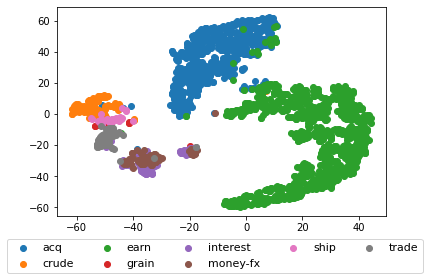

In [17]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
import os
import sys

dataset = "R8"
length = "2"

f = open('./cleaned_data/' + dataset + '/graph/' + dataset + '.train.index', 'r')
lines = f.readlines()
f.close()
train_size = len(lines)


f = open('./cleaned_data/' + dataset + '/' + dataset + '_shuffle.txt', 'r')
lines = f.readlines()
f.close()

target_names = set()
labels = []
for line in lines:
    line = line.strip()
    temp = line.split('\t')
    labels.append(temp[2])
    target_names.add(temp[2])

target_names = list(target_names)

f = open('./cleaned_data/' + dataset + '/' + dataset + '_' + length + '_vectors.txt', 'r')
lines = f.readlines()
f.close()

docs = []
for line in lines:
    temp = line.strip().split()
    values_str_list = temp[1:]
    values = [float(x) for x in values_str_list]
    docs.append(values)

fea = docs[train_size:]  # int(train_size * 0.9)
label = labels[train_size:]  # int(train_size * 0.9)
label = np.array(label)

fea = TSNE(n_components=2).fit_transform(fea)
cls = np.unique(label)


fea_num = [fea[label == i] for i in cls]
for i, f in enumerate(fea_num):
    if cls[i] in range(10):
        plt.scatter(f[:, 0], f[:, 1], label=cls[i], marker='+')
    else:
        plt.scatter(f[:, 0], f[:, 1], label=cls[i])


plt.legend(ncol=5, loc='upper center', bbox_to_anchor=(0.48, -0.08), fontsize=11)
plt.tight_layout()
plt.savefig(dataset+'_'+length+'_vis.png', format='png')